In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import tensorflow as tf

np.random.seed(13)
tf.random.set_seed(13)

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from wordcloud import WordCloud
from xml.sax import ContentHandler, parse

from nltk import word_tokenize
import nltk

#nltk.download('punkt')

stemmer = SnowballStemmer('english', ignore_stopwords=True)
stop = set(stopwords.words('english'))

%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})

2023-05-18 17:43:59.680142: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Class that hadles excel files

In [2]:
%%time

class ExcelHandler(ContentHandler):
    def __init__(self):
        self.chars = [  ]
        self.cells = [  ]
        self.rows = [  ]
        self.tables = [  ]
    def characters(self, content):
        self.chars.append(content)
    def startElement(self, name, atts):
        if name=="Cell":
            self.chars = [  ]
        elif name=="Row":
            self.cells=[  ]
        elif name=="Table":
            self.rows = [  ]
    def endElement(self, name):
        if name=="Cell":
            self.cells.append(''.join(self.chars))
        elif name=="Row":
            self.rows.append(self.cells)
        elif name=="Table":
            self.tables.append(self.rows)



CPU times: user 19 µs, sys: 2 µs, total: 21 µs
Wall time: 22.6 µs


In [3]:
excelHandler = ExcelHandler()
parse('data/features.xls', excelHandler)
features = pd.DataFrame(excelHandler.tables[0][1:], columns=excelHandler.tables[0][0])

Parse Excel file and create dataframe


In [4]:
y = np.where(features['Label'] == 'objective', 0, 1)

Create labels: objective = 0, subjective = 1

In [5]:
texts = []
normalized_texts = []

for i in range(1, 1001):
    if i // 10 == 0:
        num = '000' + str(i)
    elif i // 100 == 0:
        num = '00' + str(i)
    elif i // 1000 == 0:
        num = '0' + str(i)
    else:
        num = '1000'
    
    f = open('data/raw-data/Text' + num + '.txt', 'r', encoding='latin-1')
    text = f.read()
    
    # removes any non-alphabetic characters and tokenizes 
    # the text from the Natural Language Toolkit (nltk)
    
    normalized_text = ' '.join([stemmer.stem(w) for w in word_tokenize(text) if (w.isalpha() and w not in stop)])
    texts.append(text)
    normalized_texts.append(normalized_text)

Read text files and preprocess

In [6]:
dataframe = pd.DataFrame({'texts': np.array(texts), 'normalized_texts': np.array(normalized_texts), 'label': y})

Create dataframe for the texts and their labels

In [7]:
obj_texts = ' '.join(dataframe[dataframe['label'] == 0]['normalized_texts'].tolist())
sub_texts = ' '.join(dataframe[dataframe['label'] == 1]['normalized_texts'].tolist())

Create two strings for the preprocessed texts: one for objective and one for subjective

In [8]:
X_train, X_test, y_train, y_test = train_test_split(np.array(normalized_texts), y, random_state=13, stratify=y)

Splits the data into training and testing sets for use in a machine learning model.

# Decision Tree's

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Create an instance of the TfidfVectorize

In [10]:
vectorizer = TfidfVectorizer()

Fit the vectorizer on the training data and transform the training data

In [11]:
X_train_vectorized = vectorizer.fit_transform(X_train)

Transform the test data

In [12]:
X_test_vectorized = vectorizer.transform(X_test)

Create an instance of the DecisionTreeClassifier

In [13]:
classifier = DecisionTreeClassifier()

Fit the model on the vectorized training data

In [14]:
classifier.fit(X_train_vectorized, y_train)

DecisionTreeClassifier()

Make predictions on the vectorized test data


In [15]:
y_pred = classifier.predict(X_test_vectorized)

Summary of the predictions made by the classifier

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       159
           1       0.64      0.68      0.66        91

    accuracy                           0.74       250
   macro avg       0.72      0.73      0.73       250
weighted avg       0.75      0.74      0.75       250



#### Confusion matrix

In [17]:
print(confusion_matrix(y_test, y_pred))

[[124  35]
 [ 29  62]]


#### Accuracy Score

In [18]:
print('accuracy is',accuracy_score(y_pred,y_test))

accuracy is 0.744


# Support Vector Machine's (SVM) 

In [19]:
from sklearn.svm import SVC

Create an instance of the SVC (Support Vector Classifier)

In [20]:
classifier = SVC()

Fit the model on the vectorized training data

In [21]:
classifier.fit(X_train_vectorized, y_train)

SVC()

Make predictions on the vectorized test data

In [22]:
y_pred = classifier.predict(X_test_vectorized)

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       159
           1       0.81      0.51      0.62        91

    accuracy                           0.78       250
   macro avg       0.79      0.72      0.73       250
weighted avg       0.78      0.78      0.76       250



#### Print the confusion matrix

In [24]:
print(confusion_matrix(y_test, y_pred))

[[148  11]
 [ 45  46]]


#### Accuracy Score

In [25]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.776


# K-Nearest Neighbours

In [26]:
from sklearn.neighbors import KNeighborsClassifier

Create an instance of the KNN:

In [27]:
classifier = KNeighborsClassifier(n_neighbors=8)

Fit the model on the vectorized training data

In [28]:
classifier.fit(X_train_vectorized, y_train)

KNeighborsClassifier(n_neighbors=8)

Make predictions on the vectorized test data

In [29]:
y_pred = classifier.predict(X_test_vectorized)

Summary of the predictions made by the classifier

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76       159
           1       0.57      0.53      0.55        91

    accuracy                           0.68       250
   macro avg       0.66      0.65      0.65       250
weighted avg       0.68      0.68      0.68       250



#### Print the confusion matrix

In [31]:
print(confusion_matrix(y_test, y_pred))

[[123  36]
 [ 43  48]]


#### Accuracy Score

In [33]:
print('accuracy is',accuracy_score(y_pred,y_test))

accuracy is 0.684


# Visual Comparison between the previous algorithms

In [35]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import OneHotEncoder

Classifiers:

In [36]:
classifiers = [
    DecisionTreeClassifier(),
    SVC(),
    KNeighborsClassifier(n_neighbors=8),
]

encoder = OneHotEncoder()

Logging for Visual Comparison:

In [46]:
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train_vectorized, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test_vectorized)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    log_entry = pd.DataFrame([[name, acc*100, 11]], columns=log_cols)
    log = pd.concat([log, log_entry], ignore_index=True)
    
    print("="*30)

DecisionTreeClassifier
****Results****
Accuracy: 69.2000%
SVC
****Results****
Accuracy: 77.6000%
KNeighborsClassifier
****Results****
Accuracy: 68.4000%


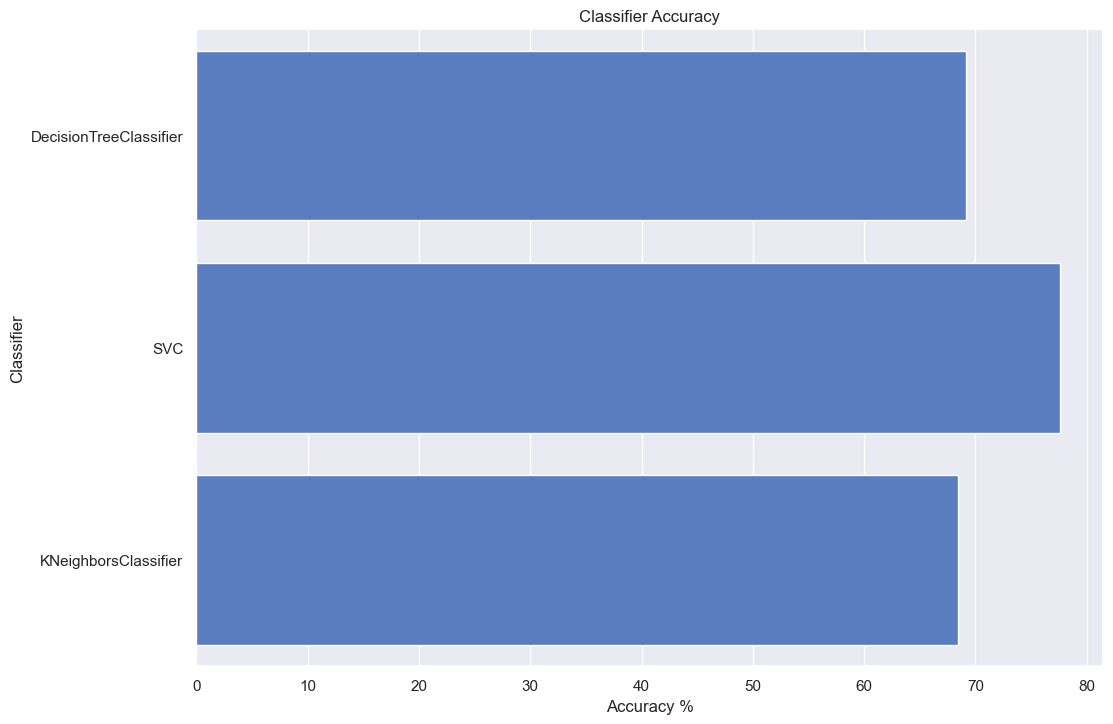

In [47]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()